# Comparison to Conformal Prediction

The goal of this experiment is to compare prediction-powered inference and a version of conformal prediction (1) as a baseline. The baseline involves using the gold-standard data to construct conformal prediction sets with the residual score function at level $\alpha/N$ for each unlabeled example. The lower- and upper- endpoints of these sets are averaged to produce a confidence interval for the mean. This confidence interval is guaranteed validity for arbitrary models and distributions. However, it is extremely conservative. An ablation is performed without a Bonferroni correction (i.e., sets were constructed at level $\alpha$ instead of $\alpha/N$), but this remains conservative and does not provide an improvement over the classical intervals.

The inferential goal is to estimate the mean income in California in the year 2019 among employed individuals. The same data is used in the notebook [```census_income.ipynb```](https://github.com/aangelopoulos/ppi_py/blob/main/examples/census_income.ipynb).

1. V. Vovk, A. Gammerman, G. Shafer, Algorithmic Learning in a Random World. vol. 5 (New York: Springer, 2005). 

### Import necessary packages

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys

sys.path.append(
    os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
)
import numpy as np
import pandas as pd
from ppi_py.datasets import load_dataset
from ppi_py import ppi_mean_ci, conformal_mean_ci
from tqdm import tqdm
from scipy.optimize import brentq
from baseline_utils import *

### Import the census income data set

Load the data. The data set contains reported income (```Y```), predicted income (```Yhat```), and age and sex (```X```).

In [2]:
dataset_folder = "../data/"
data = load_dataset(dataset_folder, "census_income")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"]

### Problem setup

Specify the error level (```alpha```), range of values for the labeled data set size (```ns```), and number of trials (```num_trials```).

Compute the ground-truth value of the estimand.

In [3]:
alpha = 0.1
n_total = Y_total.shape[0]  # Total number of labeled examples
ns = np.linspace(50, 1000, 10).astype(
    int
)  # Test for different numbers of labeled examples
num_trials = 50

# True mean (computed on all labels)
true_theta = Y_total.mean()

### Construct intervals

Form confidence intervals for all methods and problem parameters. A dataframe with the following columns is formed:
1. ```method``` (one of ```PPI```, ```Classical```, and ```Baseline```, where ```Baseline``` is the conformal prediction baseline without a Bonferroni correction and ```Classical``` is the conformal prediction baseline with a Bonferroni correction)
2. ```n``` (labeled data set size, takes values in ```ns```)
3. ```lower``` (lower endpoint of the confidence interval)
4. ```upper``` (upper endpoint of the confidence interval)
5. ```trial``` (index of trial, goes from ```0``` to ```num_trials-1```)

In [4]:
# Run prediction-powered inference and classical inference for many values of n
results = []
for i in tqdm(range(ns.shape[0])):
    for j in range(num_trials):
        # Prediction-Powered Inference
        n = ns[i]
        rand_idx = np.random.permutation(n_total)
        _Yhat = Yhat_total[rand_idx[:n]]
        _Y = Y_total[rand_idx[:n]]
        _Yhat_unlabeled = Yhat_total[rand_idx[n:]]

        # PPI interval
        ppi_ci = ppi_mean_ci(_Y, _Yhat, _Yhat_unlabeled, alpha=alpha)

        # Conformal interval + Bonferroni (valid)
        conformal_ci_valid = conformal_mean_ci(
            _Y, _Yhat, _Yhat_unlabeled, alpha=alpha, bonferroni=True
        )

        # Classical interval + no Bonferroni (invalid)
        conformal_ci_heuristic = conformal_mean_ci(
            _Y, _Yhat, _Yhat_unlabeled, alpha=alpha, bonferroni=False
        )

        # Append results
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "PPI",
                        "n": n,
                        "lower": ppi_ci[0],
                        "upper": ppi_ci[1],
                        "trial": j,
                    }
                ]
            )
        ]

        results += [
            pd.DataFrame(
                [
                    {
                        "method": "Baseline",  # Conformal baseline (No Bonferroni)
                        "n": n,
                        "lower": conformal_ci_heuristic[0],
                        "upper": conformal_ci_heuristic[1],
                        "trial": j,
                    }
                ]
            )
        ]

        results += [
            pd.DataFrame(
                [
                    {
                        "method": "Classical",  # Conformal baseline (Bonferroni) NB: just calling it "Classical" to reuse plotting
                        "n": n,
                        "lower": conformal_ci_valid[0],
                        "upper": conformal_ci_valid[1],
                        "trial": j,
                    }
                ]
            )
        ]


df = pd.concat(results, axis=0, ignore_index=True)
df["width"] = df["upper"] - df["lower"]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.20it/s]


### Plot results

Plot:
1. Five randomly chosen intervals from the dataframe for PPI and the conformal baseline without a Bonferroni correction;
2. The average interval width for PPI and the conformal baseline without a Bonferroni correction, together with a scatterplot of the widths from the five random draws.

Note that the conformal intervals with a Bonferroni correction do not render, because they are all infinite. 

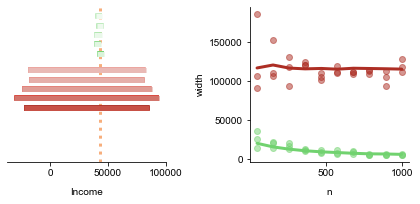

In [5]:
make_plots(
    df,
    "./plots/conformal_census_income.pdf",
    n_idx=-1,
    intervals_xlabel="Income",
    true_theta=true_theta,
)